In [5]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from sbcbinaryformat import Streamer, Writer
import scipy.signal as sg
from pathlib import Path
import pandas as pd
import re
import json
import math

ana_path = "../LAr10Ana/"
sys.path.insert(0, ana_path)
seitz_path = "../SeitzModel/"
sys.path.insert(0, seitz_path)

from GetEvent import GetEvent, GetRun
from REFPROP import SeitzModel as sm

%matplotlib inline

In [6]:
recon_path = Path("/exp/e961/data/SBC-25-recon/dev-output/")
data_path = Path("/exp/e961/data/SBC-25-daqdata/")

In [7]:
def gen_run_numbers(run_ranges):
    # input is a tuple or a list of tuples, which contains (date, start_run, end_run)
    if isinstance(run_ranges, tuple):
        run_ranges = [run_ranges]

    ret = [
        f"{date}_{run}"
        for date, start, end in run_ranges
        for run in range(start, end + 1)
    ]

    return ret

In [13]:
def get_runs_between(data_path, start_folder, end_folder):
    pattern = re.compile(r'^\d{8}_\d+.*$')
    all_folders = sorted([
        f.stem for f in data_path.iterdir()
        if pattern.match(f.name)
    ])
    
    if start_folder not in all_folders:
        raise ValueError(f"Start folder '{start_folder}' not found")
    if end_folder not in all_folders:
        raise ValueError(f"End folder '{end_folder}' not found")
    
    start_idx = all_folders.index(start_folder)
    end_idx = all_folders.index(end_folder)
    
    if start_idx > end_idx:
        start_idx, end_idx = end_idx, start_idx
    
    return all_folders[start_idx:end_idx + 1]

In [45]:
def get_livetime_by_pset_and_scint(runs, data_path="/exp/e961/data/SBC-25-daqdata/", recon_path="/exp/e961/data/SBC-25-recon/dev-output/"):
    results = {"run": [],
               "ev": [],
               "pressure": [],
               "livetime": [],
               "scint": [],
              }

    for run in runs:
        try:
            exposure = Streamer(os.path.join(recon_path, run, "exposure.sbc")).to_dict()
            event_info = Streamer(os.path.join(recon_path, run, "event.sbc")).to_dict()
            scint_rate = Streamer(os.path.join(recon_path, run, "scint_rate.sbc")).to_dict()
        except (FileNotFoundError, IndexError):
            # print(f"Run {run} file not available. Skipping...")
            continue
        
        pt2121 = exposure["PT2121_pressure"]
        livetime = exposure["PT2121_livetime"]
        scint_hits = scint_rate["n_hits"]
        scint_evs = scint_rate["ev"]

        for ev in range(len(pt2121)):
            real_p = pt2121[ev]
            try:
                pset_lo = event_info["pset_lo"][ev]
            except KeyError:
                pset_lo = event_info["pset"][ev]
            
            pset_hi = event_info["pset_hi"][ev]

            if math.isnan(real_p):
                continue
            elif pset_lo != pset_hi:
                continue
            elif abs(real_p - pset_lo) > 0.5:
                continue

            pset_bin = pset_lo
            ev_livetime = livetime[ev]

            if np.sum(scint_evs == ev) == 0:
                scint_avg = 0
            else:
                scint_avg = np.median(scint_hits[scint_evs == ev])

            results["run"].append(run)
            results["ev"].append(ev)
            results["pressure"].append(pset_bin)
            results["livetime"].append(ev_livetime)
            results["scint"].append(scint_avg)
    
    for k, v in results.items():
        results[k] = np.array(v)

    return results

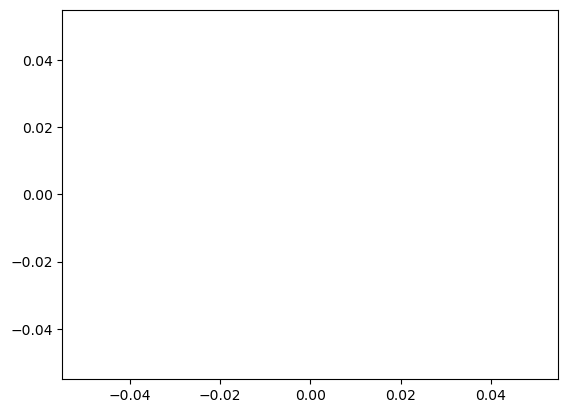

In [52]:
cs_data = ["20251213_6", "20251213_7"]
result = get_livetime_by_pset_and_scint(cs_data)
plt.scatter(result["scint"], result["livetime"])

In [53]:
result

{'run': array([], dtype=float64),
 'ev': array([], dtype=float64),
 'pressure': array([], dtype=float64),
 'livetime': array([], dtype=float64),
 'scint': array([], dtype=float64)}